In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IntTool.utils import complex_abs, fourier, apply_mask, inverse_fourier, phase, unwrap_phase, abel_inversion

In [2]:
SAVE = False

In [3]:
def phase_addition(x, y, sigma=150, phase_max=15):
    return np.exp(-(x**2 + y**2) / sigma) * phase_max

def generate_interferogram(X, Y, plasma=True, k0x=5, k0y=1, noise=False):
    phase = np.zeros((Y.size, X.size))
    for i,y in enumerate(Y):
        for j,x in enumerate(X):
            phase[i, j] = k0x * x + k0y * y
            if plasma:
                phase[i, j] += phase_addition(x, y)
            if noise:
                phase[i, j] += 0.1*np.random.rand(1)
    return 1 + 1 + 2 * np.cos(phase)

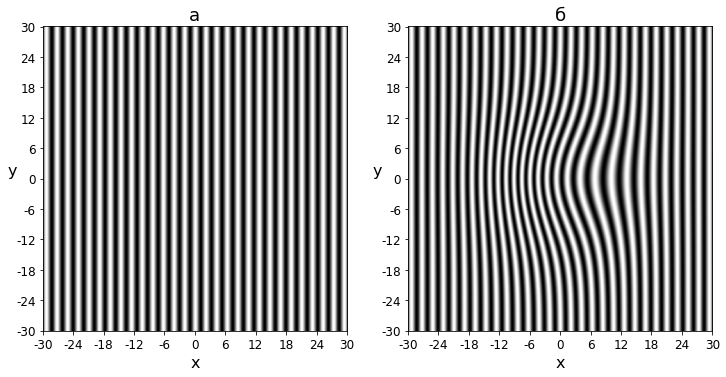

In [4]:
SIZE=2000

X = np.linspace(-30, 30, SIZE + 1)
Y = np.linspace(30, -30, SIZE + 1)


interferogram = generate_interferogram(X, Y, k0x=3, k0y=0, plasma=True, noise=False)
background = generate_interferogram(X, Y, k0x=3, k0y=0, plasma=False, noise=False)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('а', fontsize=18)
plt.imshow(background, cmap='gray')
plt.xticks(range(0, X.size, SIZE // 10), X[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.yticks(range(0, Y.size, SIZE // 10), Y[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16, rotation=0)

plt.subplot(122)
plt.title('б', fontsize=18)
plt.imshow(interferogram, cmap='gray')
plt.xticks(range(0, X.size, SIZE // 10), X[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.yticks(range(0, Y.size, SIZE // 10), Y[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16, rotation=0)
if SAVE:
    plt.savefig('./simulated_interferograms.png', dpi=100)
plt.show()

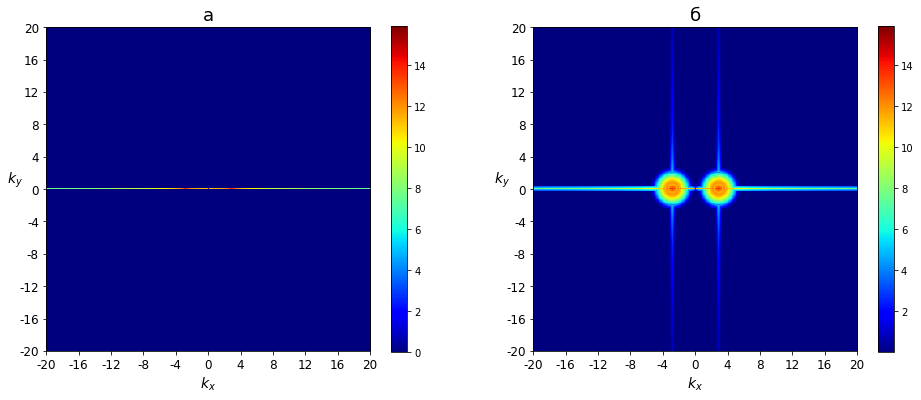

In [5]:
spectrum_pad = 800

bg_crop = np.log(complex_abs(fourier(background)) + 1)[spectrum_pad:-spectrum_pad,spectrum_pad:-spectrum_pad]
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.imshow(bg_crop, cmap='jet')
plt.xticks(range(0, bg_crop.shape[0], bg_crop.shape[0] // 10), range(-(bg_crop.shape[0]//20), bg_crop.shape[0]//20 + 1, bg_crop.shape[0] // 100), fontsize=12)
plt.yticks(range(0, bg_crop.shape[1], bg_crop.shape[1] // 10), range(bg_crop.shape[1]//20, -(bg_crop.shape[1]//20 + 1), -(bg_crop.shape[1] // 100)), fontsize=12)
plt.xlabel(r'$k_x$', fontsize=14)
plt.ylabel(r'$k_y$', fontsize=14, rotation=0)
plt.colorbar()
plt.title('а', fontsize=18)

int_crop = np.log(complex_abs(fourier(interferogram)) + 1)[spectrum_pad:-spectrum_pad,spectrum_pad:-spectrum_pad]
plt.subplot(122)
plt.imshow(int_crop, cmap='jet')
plt.xticks(range(0, int_crop.shape[0], int_crop.shape[0] // 10), range(-(int_crop.shape[0]//20), int_crop.shape[0]//20 + 1, int_crop.shape[0] // 100), fontsize=12)
plt.yticks(range(0, int_crop.shape[1], int_crop.shape[1] // 10), range(int_crop.shape[1]//20, -(int_crop.shape[1]//20 + 1), -(int_crop.shape[1] // 100)), fontsize=12)
#plt.xticks(range(0, X.size, SIZE // 10), range(-(X.size//2), X.size//2 + 1, SIZE // 10), fontsize=12)
#plt.yticks(range(0, Y.size, SIZE // 10), range(Y.size//2, -(X.size//2 + 1), -(SIZE // 10)), fontsize=12)
plt.xlabel(r'$k_x$', fontsize=14)
plt.ylabel(r'$k_y$', fontsize=14, rotation=0)
plt.colorbar()
plt.title('б', fontsize=18)
if SAVE:
    plt.savefig('./spectra_compare.png', dpi=100)
plt.show()

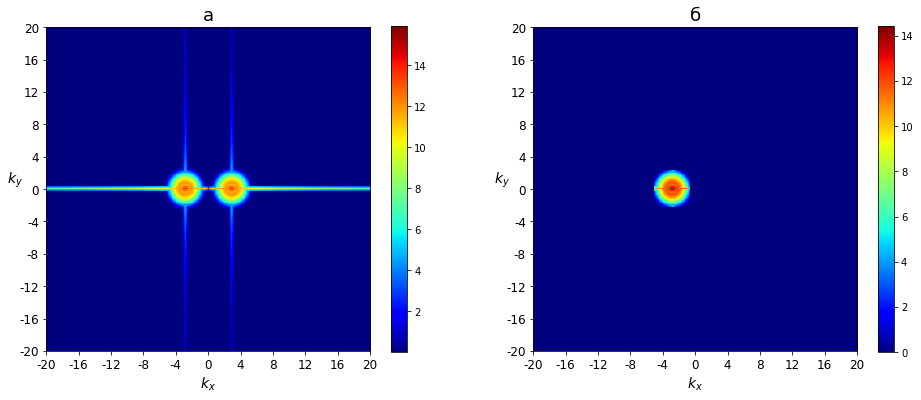

In [6]:
spectrum = fourier(interferogram)

x = np.arange(interferogram.shape[1])
y = np.arange(interferogram.shape[0])

shift_x = x.size // 2
shift_y = y.size
data = complex_abs(spectrum)[:shift_y, :shift_x]
max_id = np.array(np.unravel_index(data.argmax(), data.shape))

size = (22, 22)
area_to_show = (50, 50)
gauss_mask = False

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.imshow(
    np.log(complex_abs(spectrum) + 1)[spectrum_pad:-spectrum_pad,spectrum_pad:-spectrum_pad],
    cmap='jet'
)
plt.xticks(range(0, int_crop.shape[0], int_crop.shape[0] // 10), range(-(int_crop.shape[0]//20), int_crop.shape[0]//20 + 1, int_crop.shape[0] // 100), fontsize=12)
plt.yticks(range(0, int_crop.shape[1], int_crop.shape[1] // 10), range(int_crop.shape[1]//20, -(int_crop.shape[1]//20 + 1), -(int_crop.shape[1] // 100)), fontsize=12)
plt.xlabel(r'$k_x$', fontsize=14)
plt.ylabel(r'$k_y$', fontsize=14, rotation=0)
plt.colorbar()
plt.title('а', fontsize=18)

plt.subplot(122)
plt.imshow(
    apply_mask(
        np.log(complex_abs(spectrum) + 1),
        max_id,
        size,
        complex_mask=False,
        gauss=gauss_mask
    )[spectrum_pad:-spectrum_pad,spectrum_pad:-spectrum_pad],
    cmap='jet'
)
plt.xticks(range(0, int_crop.shape[0], int_crop.shape[0] // 10), range(-(int_crop.shape[0]//20), int_crop.shape[0]//20 + 1, int_crop.shape[0] // 100), fontsize=12)
plt.yticks(range(0, int_crop.shape[1], int_crop.shape[1] // 10), range(int_crop.shape[1]//20, -(int_crop.shape[1]//20 + 1), -(int_crop.shape[1] // 100)), fontsize=12)
plt.xlabel(r'$k_x$', fontsize=14)
plt.ylabel(r'$k_y$', fontsize=14, rotation=0)
plt.colorbar()
plt.title('б', fontsize=18)
if SAVE:
    plt.savefig('./spectral_filtering.png', dpi=100)
plt.show()

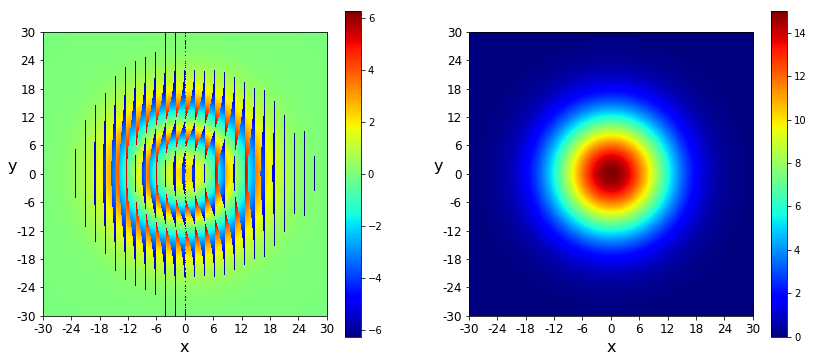

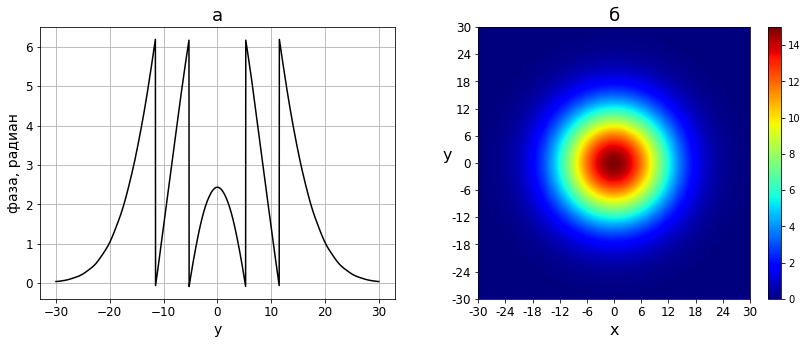

In [7]:
pad_width = 5

pad_max_id = np.array([max_id[0] + pad_width, max_id[1] + pad_width])

img_phase = phase(inverse_fourier(apply_mask(fourier(np.pad(interferogram, pad_width, 'constant')), pad_max_id, size, gauss=gauss_mask)))
back_phase = phase(inverse_fourier(apply_mask(fourier(np.pad(background, pad_width, 'constant')), pad_max_id, size, gauss=gauss_mask)))
reconstructed_phase = (-img_phase + back_phase)[pad_width:-pad_width,pad_width:-pad_width]
unwrapped_phase = unwrap_phase(reconstructed_phase)
unwrapped_phase -= unwrapped_phase.min()

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.imshow(reconstructed_phase, cmap='jet')
plt.xticks(range(0, X.size, SIZE // 10), X[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.yticks(range(0, Y.size, SIZE // 10), Y[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16, rotation=0)
plt.colorbar()

plt.subplot(122)
plt.imshow(unwrapped_phase, cmap='jet')
plt.xticks(range(0, X.size, SIZE // 10), X[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.yticks(range(0, Y.size, SIZE // 10), Y[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16, rotation=0)
plt.colorbar()
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(Y, reconstructed_phase[:,SIZE//2+1],color='black')
plt.grid()
plt.ylabel('фаза, радиан', fontsize=14)
plt.xlabel('y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('а', fontsize=18)

plt.subplot(122)
plt.imshow(unwrapped_phase, cmap='jet')
plt.xticks(range(0, X.size, SIZE // 10), X[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.yticks(range(0, Y.size, SIZE // 10), Y[range(0, X.size, SIZE // 10)].astype('int'), fontsize=12)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16, rotation=0)
plt.colorbar()
plt.title('б', fontsize=18)
if SAVE:
    plt.savefig('./reconstructed_2D_fourier_2pi.png', dpi=100)
plt.show()

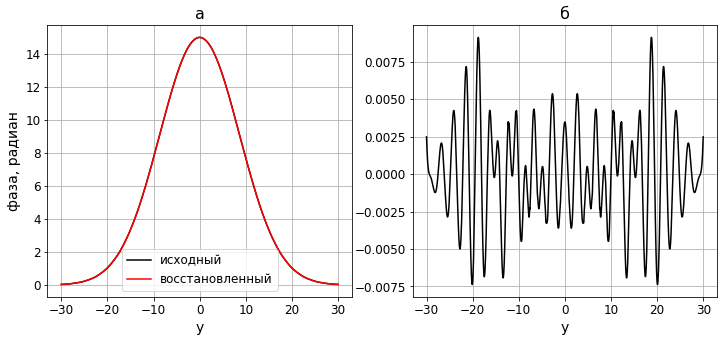

In [8]:
retrieved_phase_r = unwrapped_phase[:, SIZE // 2]

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('а', fontsize=16)
plt.plot(Y, retrieved_phase_r, label='исходный', color='black')
plt.plot(Y, phase_addition(0, Y), label='восстановленный', color='red')
plt.xlabel('y', fontsize=14)
plt.ylabel('фаза, радиан', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid()

plt.subplot(122)
plt.title('б', fontsize=16)
plt.grid()
plt.plot(Y, retrieved_phase_r - phase_addition(0, Y), color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('y', fontsize=14)
if SAVE:
    plt.savefig('./reconstruct_error.png', dpi=120)
plt.show()

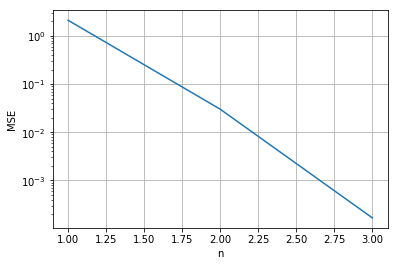

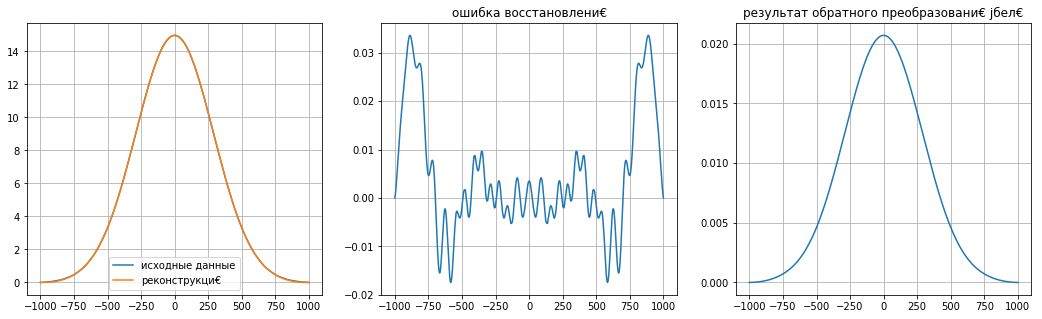

In [9]:
H_y, f_r = abel_inversion(retrieved_phase_r, n_max=3, path_to_save='./abel_coefs/')

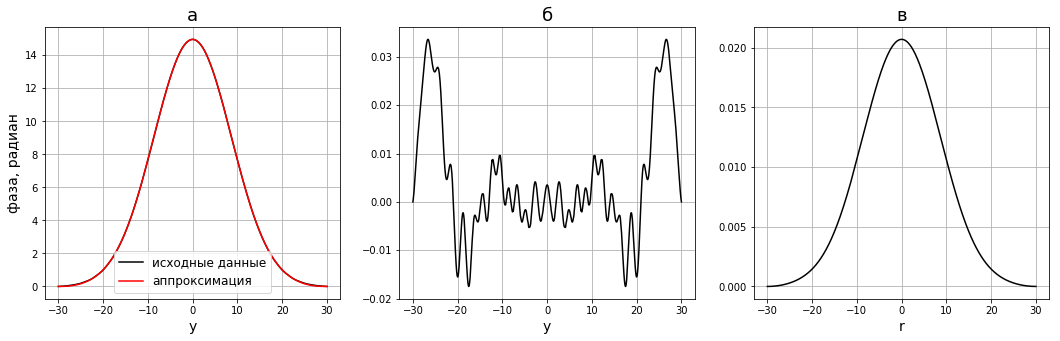

In [10]:
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(Y, retrieved_phase_r, label='исходные данные', color='black')
plt.plot(Y, H_y, label='аппроксимация', color='red')
plt.legend(fontsize=12)
plt.xlabel('y', fontsize=14)
plt.ylabel('фаза, радиан', fontsize=14)
plt.title('а', fontsize=18)

plt.grid()

plt.subplot(132)
plt.title('б', fontsize=18)
plt.plot(Y, (retrieved_phase_r - H_y), 'black')
plt.xlabel('y', fontsize=14)
plt.grid()

plt.subplot(133)
plt.title('в', fontsize=18)
plt.plot(Y, f_r, 'black')
plt.xlabel('r', fontsize=14)
plt.grid()
if SAVE:
    plt.savefig('./abel_example.png', dpi=150)
plt.show()